<a href="https://colab.research.google.com/github/dimakpa/DL_Projects/blob/main/ResNet18_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Подготовка датасета

Первым делом создадим датасет из кинопетель, взяв каждую 5 картинку


In [68]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pathlib import Path

# specify GPU
device = torch.device("cuda")

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
df = pd.DataFrame(pd.read_excel("/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/data/classes.xlsx"))

df.head()

,№,"Узел ЩЖ, TIRADS"
0,178,4
1,179,5
2,180,3
3,181,5
4,182,3


Для удобства поменяем тирадс на 0 и 1

In [71]:
# df.loc[df['Узел ЩЖ, TIRADS'] < 5, 'Узел ЩЖ, TIRADS'] = 0
# df.loc[df['Узел ЩЖ, TIRADS'] > 4, 'Узел ЩЖ, TIRADS'] = 1
# df.head()

Напишем функцию, которая достает каждое пятое изображение из кинопетли

In [72]:
from PIL import Image
im = Image.open('/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/data/178/178_TIRADS4_long.tif')
im.show()

In [73]:
im.n_frames

121

In [74]:
def parse_tif(filePath, fileSave, numOfBlock):
    if Path(filePath).is_file():
      img = Image.open(filePath)
      numFramesPerTif = img.n_frames
      for i in range (numFramesPerTif):
          if i%5 == 0:
              try:
                  img.seek(i)
                  img.save(fileSave + numOfBlock +'Block_%s.jpg'%(i,))
              except EOFError: #end of file error
                  print('End of file error')


In [75]:
# parse_tif('/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/data/178/178_TIRADS4_long.tif', '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/data', '2228' )

Теперь извлечем каждое пятое фото из всех кинопетель и сохраним в отедльных папках для бинарной классификации.

0 - в одной
1 - в другой

Поменяем имена столбцов для удобства

In [76]:
df = df.rename(columns={'№': 'id', 'Узел ЩЖ, TIRADS': 'predict'})

In [77]:
zero_df = df[df['predict'] < 5]
one_df = df[df['predict'] == 5]

zero_df.head()

,id,predict
0,178,4
2,180,3
4,182,3
10,188,3
11,189,4


In [78]:
save_path0 = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/train_data_jpg/zero/'
for index, row in zero_df.iterrows ():
  parse_tif('/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/data/' + str(row['id']) + '/' + str(row['id']) + '_TIRADS' + str(row['predict']) + '_cross.tif', save_path0, str(row['id']) )
  parse_tif('/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/data/' + str(row['id']) + '/' + str(row['id']) + '_TIRADS' + str(row['predict']) + '_long.tif', save_path0, str(row['id']) )
#  print(row['predict'])


In [79]:
save_path1 = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/train_data_jpg/one/'
for index, row in one_df.iterrows ():
  parse_tif('/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/data/' + str(row['id']) + '/' + str(row['id']) + '_TIRADS' + str(row['predict']) + '_cross.tif', save_path1, str(row['id']) )
  parse_tif('/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/data/' + str(row['id']) + '/' + str(row['id']) + '_TIRADS' + str(row['predict']) + '_long.tif', save_path1, str(row['id']) )

Разделим теперь на тренировочную и тестовую выборки

In [80]:
pip install split-folders

Тестовая выборка не нужна, ограничимся валидационной и тренировочной для улучшения результата

In [81]:
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/train_data_jpg', output="/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output", seed=1337, ratio=(.85, 0.15, 0))


Copying files: 841 files [00:17, 49.29 files/s]


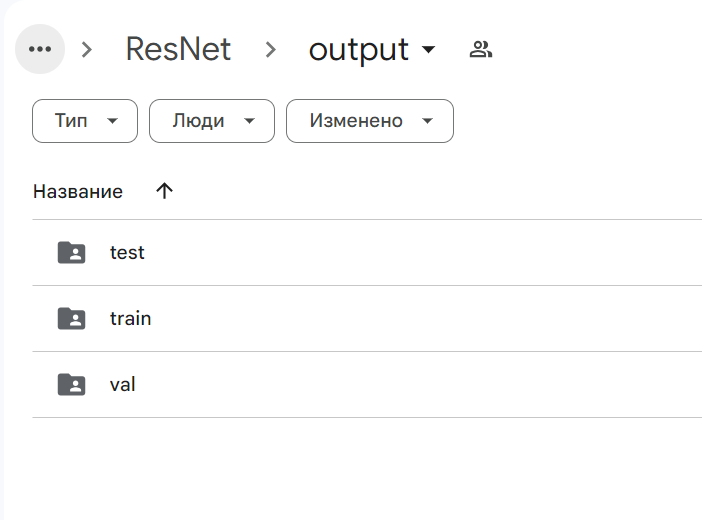

Данные готовы к обучению

#Подготовка модели

In [82]:
import os
from time import time
from tqdm import tqdm
import numpy

import torch
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.transforms import transforms


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Создадим трансфермер для данных

Вращать картинки смысла нет

In [83]:
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Создадим датасет

In [84]:
TRAIN_ROOT = "/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output/train"
# TEST_ROOT = "/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output/test"
VAL_ROOT = "/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output/val"

train_ds = ImageFolder(TRAIN_ROOT, transform=tfm)
# test_ds = ImageFolder(TEST_ROOT, transform=tfm)
val_ds = ImageFolder(VAL_ROOT, transform=tfm)

Посмотрим на данные

In [85]:
LEN_TRAIN = len(train_ds)
# LEN_TEST = len(test_ds)
LEN_VAL = len(val_ds)
print(f'Len of Train: {LEN_TRAIN} , Len of val: {LEN_VAL} ') #, Len of Test: {LEN_TEST}  ')

print(train_ds.class_to_idx)

Len of Train: 713 , Len of val: 126 
{'one': 0, 'zero': 1}


Создадим загрузчик данных батчами

In [86]:
train_loader = DataLoader(train_ds, batch_size = 30, shuffle=True)
# test_loader = DataLoader(test_ds, batch_size=30, shuffle = True)
val_loader = DataLoader(val_ds, batch_size=30, shuffle = True)

Создадим модель ResNet-18

In [87]:
model = resnet18(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Заменим выходной линейных слой, чтоб на вызоде было 2 фичи

In [88]:
model.fc = Linear(in_features=512, out_features=2)
model = model.to(device)
# model = model.cuda()

Зададим оптимизатор и лосс функцию

In [89]:
optimiser = Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)

loss_fn = CrossEntropyLoss()

#Приступим к тренировке модели

In [90]:
EPOSH = 15
validation_accuracy = [] #
train_accuracy = [] #

validation_losses = [] #
train_losses = [] #

epoch_list = []

In [91]:
for epoch in range(EPOSH):
    epoch+=1
    epoch_list.append(epoch)
    start = time()

    tr_acc = 0
    val_acc = 0

    # Train
    model.train()

    with tqdm(train_loader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimiser.zero_grad()

            #forward & backward
            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()

            train_loss = loss_fn(train_prob, ytrain)
            train_loss.backward()
            optimiser.step()

            # training ends

            train_pred = torch.max(train_prob, 1).indices
            tr_acc += int(torch.sum(train_pred == ytrain))

        ep_tr_acc = tr_acc / LEN_TRAIN

    # Evaluate
    model.eval()
    with torch.no_grad():
        for xval, yval in val_loader:
            xval = xval.to(device)
            val_prob = model(xval)
            val_prob = val_prob.cpu()

            val_pred = torch.max(val_prob,1).indices
            val_acc += int(torch.sum(val_pred == yval))

            valid_loss = loss_fn(val_prob, yval)

        ep_val_acc = val_acc / LEN_VAL

    end = time()
    duration = (end - start) / 60

    validation_losses.append(valid_loss)
    train_losses.append(train_loss)

    validation_accuracy.append(ep_val_acc)
    train_accuracy.append(ep_tr_acc)

    print(f"Epoch: {epoch}, Time: {duration},\nTrain loss: {train_loss}, Validation loss: {valid_loss} \nTrain_acc: {ep_tr_acc}, Val_acc: {ep_val_acc}")

100%|██████████| 24/24 [03:54<00:00,  9.75s/batch]


Epoch: 1, Time: 4.095982865492503,
Train loss: 0.13100288808345795, Validation loss: 0.3985464870929718 
Train_acc: 0.8457223001402524, Val_acc: 0.7063492063492064


100%|██████████| 24/24 [03:33<00:00,  8.90s/batch]


Epoch: 2, Time: 3.7752321561177573,
Train loss: 0.05125987157225609, Validation loss: 0.0016808310756459832 
Train_acc: 0.9845722300140253, Val_acc: 1.0


100%|██████████| 24/24 [03:32<00:00,  8.86s/batch]


Epoch: 3, Time: 3.764577587445577,
Train loss: 0.09031263738870621, Validation loss: 0.041400518268346786 
Train_acc: 0.9971949509116409, Val_acc: 0.9920634920634921


100%|██████████| 24/24 [03:36<00:00,  9.01s/batch]


Epoch: 4, Time: 3.8563130021095278,
Train loss: 0.007740730885416269, Validation loss: 0.047330815345048904 
Train_acc: 0.9901823281907434, Val_acc: 0.9841269841269841


100%|██████████| 24/24 [03:32<00:00,  8.85s/batch]


Epoch: 5, Time: 3.752415184179942,
Train loss: 0.0006412574439309537, Validation loss: 0.00019008609524462372 
Train_acc: 0.9985974754558204, Val_acc: 1.0


100%|██████████| 24/24 [03:28<00:00,  8.68s/batch]


Epoch: 6, Time: 3.6813414732615155,
Train loss: 0.00011993835505563766, Validation loss: 0.004607574548572302 
Train_acc: 0.9985974754558204, Val_acc: 0.9920634920634921


100%|██████████| 24/24 [03:31<00:00,  8.80s/batch]


Epoch: 7, Time: 3.7341872731844585,
Train loss: 0.005202068481594324, Validation loss: 0.4784241020679474 
Train_acc: 0.9803646563814866, Val_acc: 0.8888888888888888


100%|██████████| 24/24 [03:31<00:00,  8.81s/batch]


Epoch: 8, Time: 3.739755594730377,
Train loss: 0.24249373376369476, Validation loss: 0.09005841612815857 
Train_acc: 0.9887798036465638, Val_acc: 0.9682539682539683


100%|██████████| 24/24 [03:32<00:00,  8.85s/batch]


Epoch: 9, Time: 3.7820143699645996,
Train loss: 0.0022626053541898727, Validation loss: 0.00015327507571782917 
Train_acc: 0.9803646563814866, Val_acc: 0.9920634920634921


100%|██████████| 24/24 [03:31<00:00,  8.79s/batch]


Epoch: 10, Time: 3.7329417943954466,
Train loss: 0.004695124924182892, Validation loss: 0.021816326305270195 
Train_acc: 0.9929873772791024, Val_acc: 0.9841269841269841


100%|██████████| 24/24 [03:29<00:00,  8.73s/batch]


Epoch: 11, Time: 3.704097294807434,
Train loss: 0.0018540992168709636, Validation loss: 0.006900345906615257 
Train_acc: 0.9915848527349228, Val_acc: 1.0


100%|██████████| 24/24 [03:32<00:00,  8.85s/batch]


Epoch: 12, Time: 3.754653223355611,
Train loss: 0.0007365618948824704, Validation loss: 0.0001824251376092434 
Train_acc: 0.9957924263674615, Val_acc: 1.0


100%|██████████| 24/24 [03:32<00:00,  8.85s/batch]


Epoch: 13, Time: 3.7433802644411722,
Train loss: 0.0031331961508840322, Validation loss: 0.0011762080248445272 
Train_acc: 0.9859747545582047, Val_acc: 0.9761904761904762


100%|██████████| 24/24 [03:32<00:00,  8.84s/batch]


Epoch: 14, Time: 3.74662823677063,
Train loss: 0.0006492047104984522, Validation loss: 0.006929293274879456 
Train_acc: 0.9887798036465638, Val_acc: 0.9920634920634921


100%|██████████| 24/24 [03:31<00:00,  8.80s/batch]


Epoch: 15, Time: 3.7356797734896343,
Train loss: 0.0008238997543230653, Validation loss: 0.009783845394849777 
Train_acc: 0.9971949509116409, Val_acc: 0.9920634920634921


#Проверка на тестовой выборке

In [92]:
# for x, y in test_loader:
#   x, y
#   break
# x.shape, y.shape

Найдем accuracy на тестовой

In [93]:
# test_acc = 0
# batches = 0

# model.eval()
# with torch.no_grad():
#     for xtest, ytest in test_loader:
#         batches+=1
#         xtest = xtest.to(device)
#         test_prob = model(xtest)
#         test_prob = test_prob.cpu()

#         test_pred = torch.max(test_prob,1).indices
#         print(int(torch.sum(test_pred == ytest)))
#         test_acc += int(torch.sum(test_pred == ytest))

#     ep_test_acc = test_acc / LEN_TEST

# batches_list = [i for i in range(1, batches+1)]

# print(f"Test_acc: {ep_test_acc}")

In [94]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

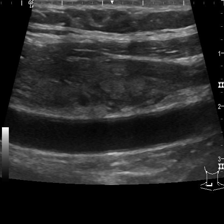

In [96]:
from PIL import Image

img = pil_loader('/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output/val/one/179Block_5.jpg')
display(img.resize((224, 224)))
# img_array = np.array(img)
img_tensor = tfm(img)

Проверим с обычными избражениями

In [97]:
sample_1 = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output/val/one/179Block_5.jpg'
sample_2 = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output/val/one/186Block_115.jpg'
sample_3 = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output/val/zero/193Block_65.jpg'
sample_4 = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output/val/zero/199Block_30.jpg'

sample_list = [sample_1,sample_2,sample_3,sample_4]

In [98]:
# test_loader.batch_size

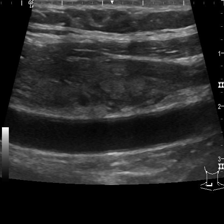

Model prediction 0, 0


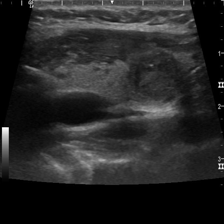

Model prediction 0, 0


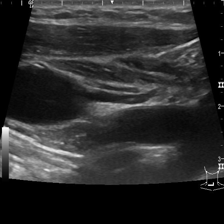

Model prediction 1, 1


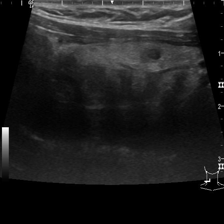

Model prediction 1, 1


In [99]:
from PIL import Image
import numpy as np

for image_path in sample_list:
    img = pil_loader(image_path)
    display(img.resize((224,224)))
    img_tensor = tfm(img)
    img_tensor = img_tensor[np.newaxis, :]
    img_tensor = img_tensor.to(device)
    pred_prob = model(img_tensor)
    pred = torch.max(pred_prob,1).indices
    pred = pred.item()
    if pred == 1:
        print(f"Model prediction {pred}, 1")
    else:
        print(f"Model prediction {pred}, 0")

    print("========================================================")

#ГРАФИКИ

In [100]:
train_losses[0].detach().numpy().astype(float).item()

0.13100288808345795

In [101]:
validation_accuracy

[0.7063492063492064,
 1.0,
 0.9920634920634921,
 0.9841269841269841,
 1.0,
 0.9920634920634921,
 0.8888888888888888,
 0.9682539682539683,
 0.9920634920634921,
 0.9841269841269841,
 1.0,
 1.0,
 0.9761904761904762,
 0.9920634920634921,
 0.9920634920634921]

In [102]:
ls = []
for i in train_losses:
  ls.append(i.detach().numpy().astype(float).item())
train_losses = ls

ls = []
for i in validation_losses:
  ls.append(i.detach().numpy().astype(float).item())
validation_losses = ls

Графики ЛОССов на тренировочной и валидационной выборках

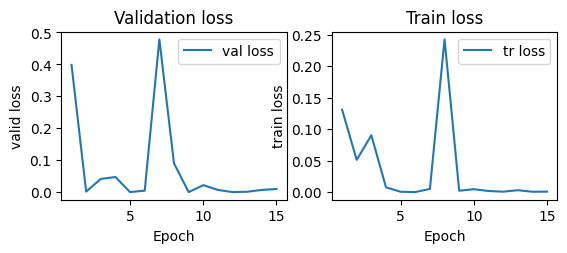

In [103]:
x_data3 = epoch_list
y_data3 = validation_losses

x_data4 = epoch_list
y_data4 = train_losses

# y_data2 = train_losses

fig = plt.figure()
ax3 = fig.add_subplot(2, 2, 1)
ax3.plot(x_data3, y_data3, label='val loss')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('valid loss')
ax3.set_title('Validation loss')
ax3.legend()

ax4 = fig.add_subplot(2, 2, 2)
ax4.plot(x_data4, y_data4, label='tr loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('train loss')
ax4.set_title('Train loss')
ax4.legend()

plt.show()

Графики ACURACY на тренировочной и валидационной выборках

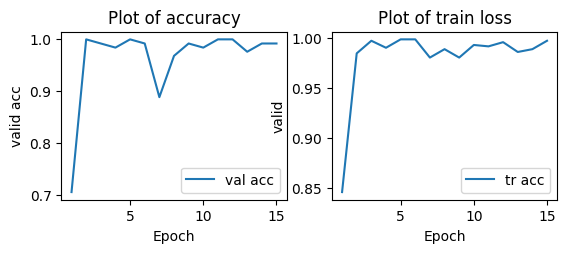

In [104]:
from matplotlib import pyplot as plt


x_data1 = epoch_list
y_data1 = validation_accuracy

x_data2 = epoch_list
y_data2 = train_accuracy

# y_data2 = train_losses

fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(x_data1, y_data1, label='val acc')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('valid acc')
ax1.set_title('Plot of accuracy')
ax1.legend()

ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(x_data2, y_data2, label='tr acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('valid')
ax2.set_title('Plot of train loss')
ax2.legend()

plt.show()

В Последнем батче большая ошибка, потому что батч неполный

In [105]:
torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/MEPHI/ResNet/model.pth')